## Applying the XGBoost algorithm ##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb
import holidays

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# input dataset
input_file = "./drive/My Drive/remote_communities/data/all_combined_training.csv"
validation_file = "./drive/My Drive/remote_communities/data/all_combined_validation.csv"
# TODO: XGBoost parameters

In [4]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [86]:
# list population per each unique latitute
lat_population = df.groupby('lat').population.mean()
# lat_population
lat_population.reindex([i for i in lat_population.index])
lat_population

lat
55.27987     686.0
58.10006    2754.0
58.45424    1757.0
58.68000     942.0
59.31042     209.0
60.01732     567.0
61.03000     403.0
62.20071    1483.0
62.41657     414.0
Name: population, dtype: float64

In [8]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [9]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date
216367,2013,9,13,6,349.481083,60.01732,-70.02754,567,582.943444,-0.418799,2013-09-13
207601,2015,9,13,0,371.750000,58.68000,-65.95000,942,756.806609,8.269922,2015-09-13


In [10]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date
37039,2014,3,25,7,1039.59625,58.45424,-78.10301,1757,1662.384400,-20.210928,2014-03-25
107728,2013,4,19,16,203.42000,59.31042,-69.59216,209,308.388576,-15.141211,2013-04-19


## Power consumption per capita

In [11]:
dfc ['weekday'] = dfc['date'].dt.weekday

In [12]:
# obtain all the holidays dates during the studied timeline
holiday_list = []
for holiday in holidays.Canada (years=[2013, 2014,2015]).items():
    holiday_list.append(holiday)

holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holiday_dates = list(holidays_df['date'])
print(holiday_dates[:5])
holidays_df.head()

[datetime.date(2013, 1, 1), datetime.date(2013, 2, 18), datetime.date(2013, 3, 29), datetime.date(2013, 5, 20), datetime.date(2013, 7, 1)]


,date,holiday
0,2013-01-01,New Year's Day
1,2013-02-18,Family Day
2,2013-03-29,Good Friday
3,2013-05-20,Victoria Day
4,2013-07-01,Canada Day


In [13]:
# define function to create a new boolian column "is_holiday"
def holiday_checker(date):
  is_holiday = date.date() in holiday_dates
  return(is_holiday)


dfc["is_holiday"] = dfc["date"].apply(lambda x: holiday_checker(x))

In [25]:
print('total number of hours is',len(dfc))
holiday_hours = dfc.groupby('is_holiday')['is_holiday'].sum()
print('total holiday hours is', holiday_hours[True])
print('ratio of holiday hours is',holiday_hours[True]/len(dfc))

total number of hours is 236424
total holiday hours is 6480
ratio of holiday hours is 0.02740838493553954


In [15]:
dfc['Kw_per_capita'] = dfc['Kw']/dfc['population']


In [16]:
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','lon'],
         axis = 1, inplace = True)
# I am maintaining lat, Kw_per_capita, date, temp, weekday_name and hour features
dfc.tail()

,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
236516,19,60.01732,-19.957297,2015-12-31,3,False,0.640062
236517,20,60.01732,-20.051184,2015-12-31,3,False,0.648297
236518,21,60.01732,-19.845023,2015-12-31,3,False,0.644289
236519,22,60.01732,-20.679938,2015-12-31,3,False,0.637535
236520,23,60.01732,-21.149695,2015-12-31,3,False,0.632873


Data transformations to normalize data (both value and distribution)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b9d5f6b10>,
      dtype=object)

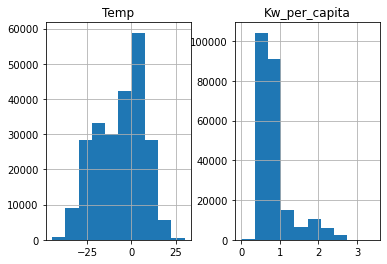

In [31]:
# inspect distribution
dfc[['Temp','Kw_per_capita']].hist()

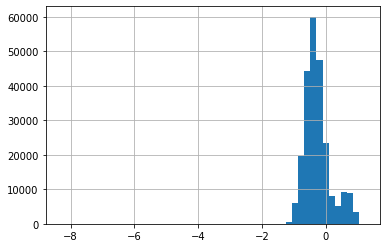

In [34]:
# explore log transformation of Kw_per_capita
np.log(dfc['Kw_per_capita']).hist(bins=50)

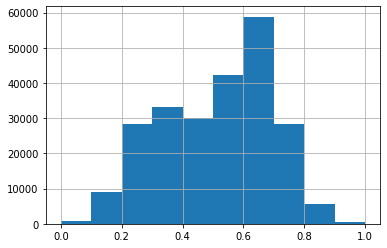

In [47]:
# explore min-max scaler on temp
normalized_temp = (dfc['Temp'] - np.min(dfc['Temp']))/(np.max(dfc['Temp'])-np.min(dfc['Temp']))
normalized_temp.hist()

In [45]:
np.min(dfc['Temp'])

-44.79054871

In [46]:
np.max(dfc['Temp'])

29.95424805

## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [52]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [49]:
# create a list of dataframe names
s=[]
for i in range(9):
    s.append('df'+str(i+1))
# print(s)

i=0
for key in dfc['lat'].value_counts().keys():
#     print(key)
    s[i]=dfc[dfc['lat']==key]
#     print(name.head(2))
#     print('\n')
    i=i+1


In [50]:
# s[0] is df1, s[1] is df2, .........
s[0].sample(5)

,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
29735,23,58.45424,-1.370459,2013-05-24,4,False,0.548794
43584,0,58.45424,-7.221045,2014-12-23,1,False,0.647830
36409,1,58.45424,-29.403387,2014-02-27,3,False,0.615099
40946,2,58.45424,7.274561,2014-09-04,3,False,0.436993
35890,10,58.45424,-22.802191,2014-02-05,2,False,0.783053


### Aggregate the data by date, which means sum up all the hourly consumptions

Commenting the following aggregation to maintain hourly resolution

In [51]:
# df1=s[0].groupby('date')['Kw_per_capita'].sum().reset_index()
df1=s[0].sort_values(by=['date','hour'])
df1 = df1.reset_index()
# df1['date'].value_counts()
df1.head(10)

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718
5,26285,5,58.45424,-18.904410,2013-01-01,1,True,0.541424
6,26286,6,58.45424,-19.061163,2013-01-01,1,True,0.535962
7,26287,7,58.45424,-19.123877,2013-01-01,1,True,0.557908
8,26288,8,58.45424,-19.240210,2013-01-01,1,True,0.560035
9,26289,9,58.45424,-19.228918,2013-01-01,1,True,0.556101


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b6c57b950>,
      dtype=object)

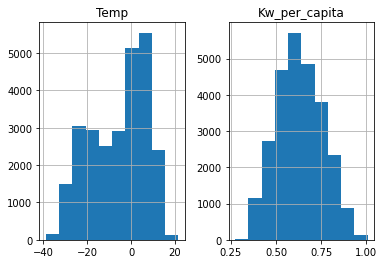

In [53]:
# inspect distribution
df1[['Temp','Kw_per_capita']].hist()

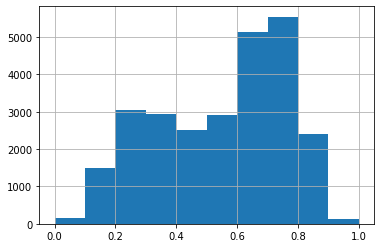

In [54]:
# explore min-max scaler on temp
normalized_temp = (df1['Temp'] - np.min(df1['Temp']))/(np.max(df1['Temp'])-np.min(df1['Temp']))
normalized_temp.hist()

In [55]:
# add normalized temp to df1

df1['normalized_temp'] = (df1['Temp'] - np.min(df1['Temp']))/(np.max(df1['Temp'])-np.min(df1['Temp']))
df1.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101,0.341867
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210,0.334131
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302,0.329154
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865,0.330429
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718,0.327232


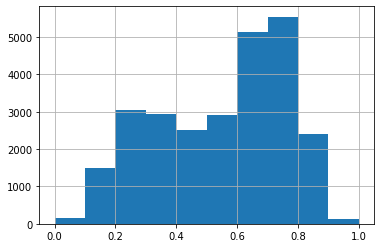

In [56]:
df1['normalized_temp'].hist()

In [57]:
df1['index_number'] = list(df1.index)
df1.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101,0.341867,0
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210,0.334131,1
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302,0.329154,2
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865,0.330429,3
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718,0.327232,4


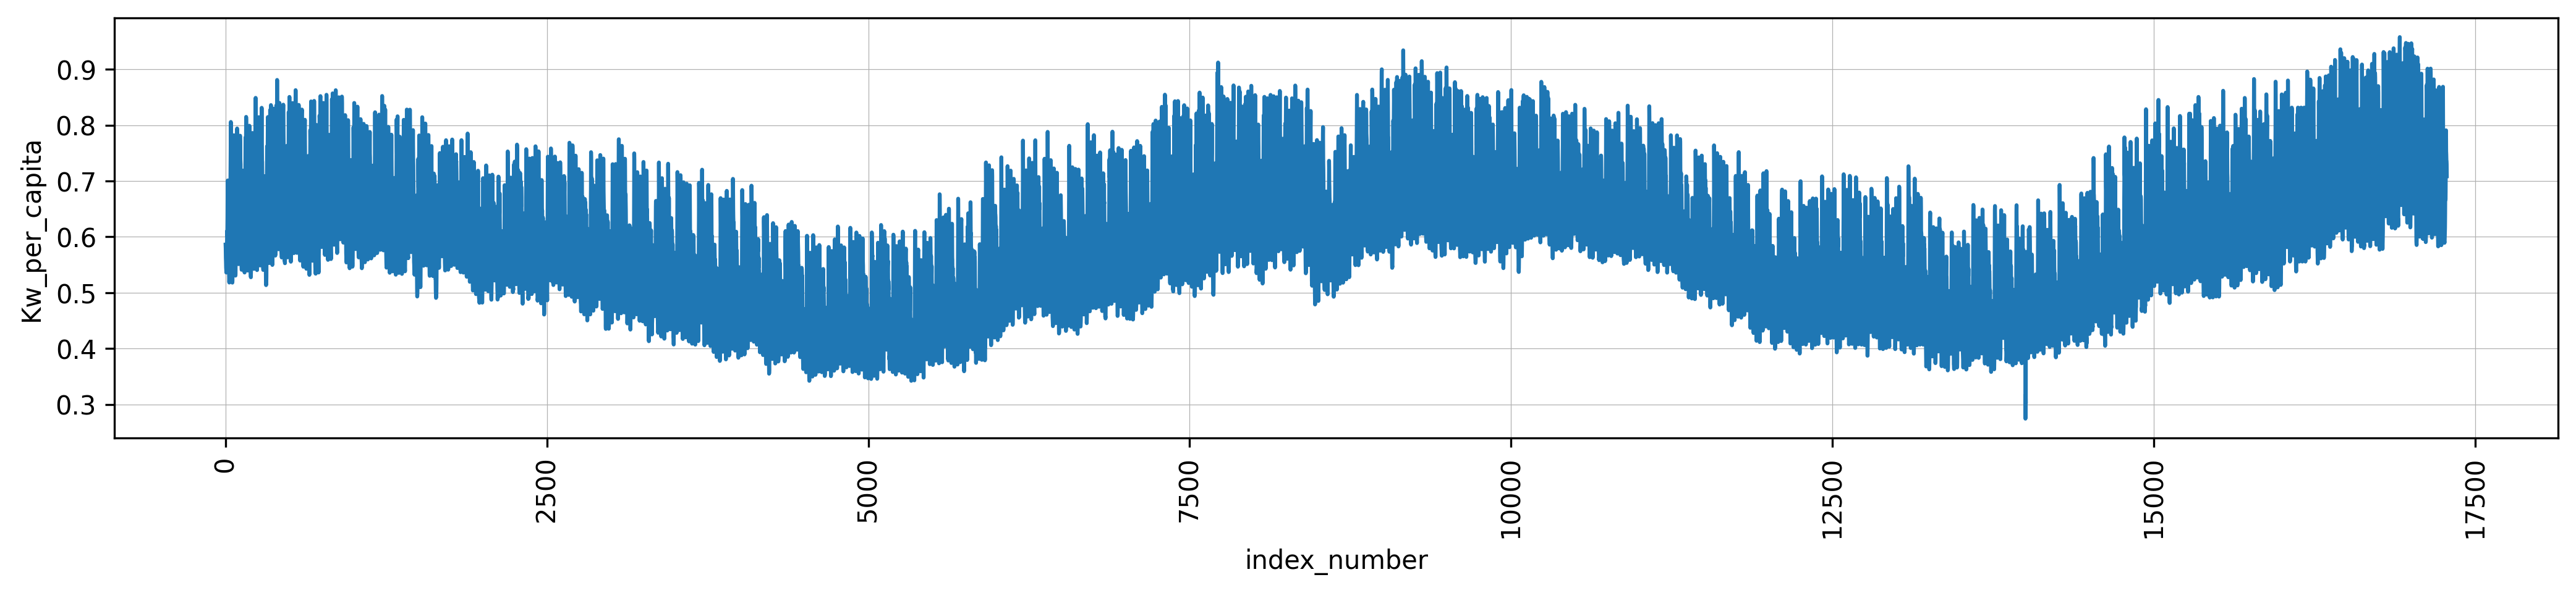

In [58]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.head(17280), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

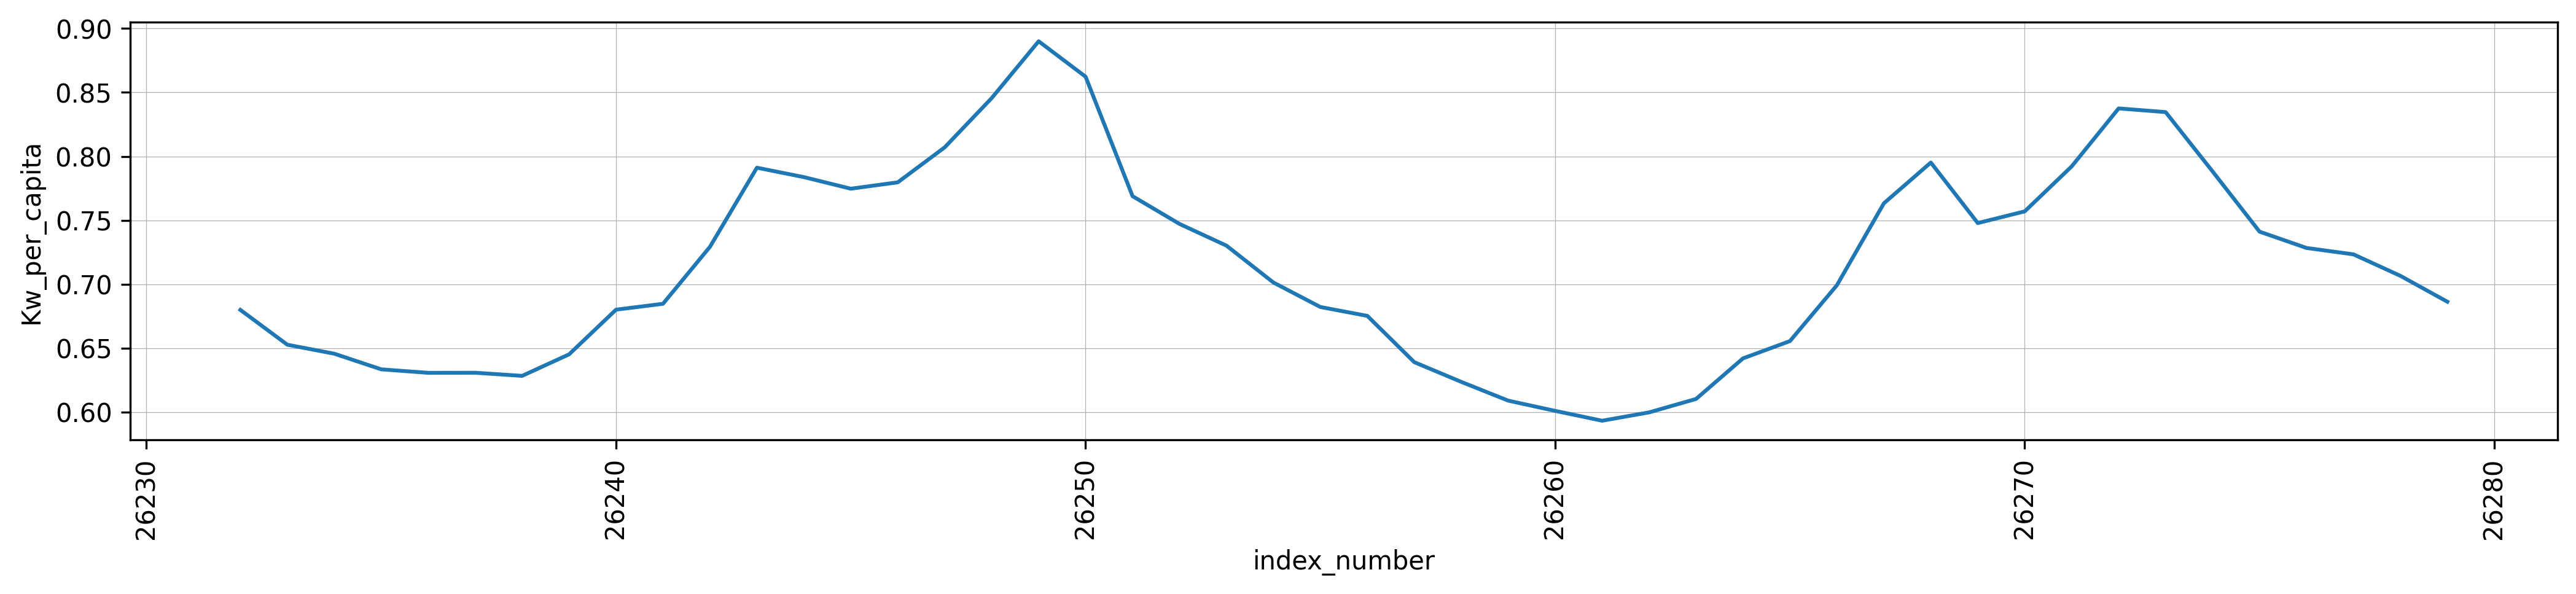

In [59]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.tail(48), x= 'index_number', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [60]:
# see if there are any missing values
df1.isna().sum()

index              0
hour               0
lat                0
Temp               0
date               0
weekday            0
is_holiday         0
Kw_per_capita      0
normalized_temp    0
index_number       0
dtype: int64

## Feature engineering

In [61]:
df1.tail(2)

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number
26278,52558,22,58.45424,-12.765479,2015-12-31,3,False,0.706639,0.432196,26278
26279,52559,23,58.45424,-12.875342,2015-12-31,3,False,0.686411,0.430374,26279


In [66]:
df1['last3d']=df1['Kw_per_capita']
for i in range(72,len(df1)):
  s = 0
  for n in range(i-72,i):
    s+=df1['Kw_per_capita'][n]
  df1['last3d'][i]=s 

df1[70:75]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d
70,26350,22,58.45424,-20.090369,2013-01-03,3,False,0.645720,0.310712,70,0.645720,0.645720
71,26351,23,58.45424,-20.402045,2013-01-03,3,False,0.620589,0.305543,71,0.620589,0.620589
72,26352,0,58.45424,-20.375937,2013-01-04,4,False,0.589926,0.305976,72,45.209676,0.589926
73,26353,1,58.45424,-20.498969,2013-01-04,4,False,0.564234,0.303936,73,45.213501,0.564234
74,26354,2,58.45424,-20.408423,2013-01-04,4,False,0.543940,0.305437,74,45.198525,0.543940


In [67]:
df1['last7d']=df1['Kw_per_capita']
for i in range(168,len(df1)):
  s = 0
  for n in range(i-168,i):
    s+=df1['Kw_per_capita'][n]
  df1['last7d'][i]=s 

df1[165:170]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d
165,26445,21,58.45424,-22.912634,2013-01-07,0,False,0.697553,0.263905,165,46.874062,0.697553
166,26446,22,58.45424,-22.183493,2013-01-07,0,False,0.683244,0.275998,166,46.869489,0.683244
167,26447,23,58.45424,-22.127188,2013-01-07,0,False,0.661275,0.276932,167,46.862125,0.661275
168,26448,0,58.45424,-21.946951,2013-01-08,1,False,0.599979,0.279921,168,46.858210,107.813914
169,26449,1,58.45424,-21.765051,2013-01-08,1,False,0.575369,0.282938,169,46.831803,107.827792


In [68]:
df1[24:29]

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d
24,26304,0,58.45424,-19.384024,2013-01-02,2,False,0.574695,0.322427,24,0.574695,0.574695
25,26305,1,58.45424,-19.444266,2013-01-02,2,False,0.561368,0.321428,25,0.561368,0.561368
26,26306,2,58.45424,-19.418188,2013-01-02,2,False,0.547498,0.321861,26,0.547498,0.547498
27,26307,3,58.45424,-19.286749,2013-01-02,2,False,0.535184,0.324041,27,0.535184,0.535184
28,26308,4,58.45424,-19.303625,2013-01-02,2,False,0.519964,0.323761,28,0.519964,0.519964


In [171]:
# shit the Kw-per_capita column down 
df1_shifted = df1.copy()
df1_shifted['Kw_next24hr'] = df1_shifted['Kw_per_capita'].shift(-24)
df1_shifted.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr
0,26280,0,58.45424,-18.211905,2013-01-01,1,True,0.586101,0.341867,0,0.586101,0.586101,0.574695
1,26281,1,58.45424,-18.678336,2013-01-01,1,True,0.579210,0.334131,1,0.579210,0.579210,0.561368
2,26282,2,58.45424,-18.978430,2013-01-01,1,True,0.562302,0.329154,2,0.562302,0.562302,0.547498
3,26283,3,58.45424,-18.901541,2013-01-01,1,True,0.555865,0.330429,3,0.555865,0.555865,0.535184
4,26284,4,58.45424,-19.094290,2013-01-01,1,True,0.544718,0.327232,4,0.544718,0.544718,0.519964


In [172]:
df1_shifted[-26:]

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr
26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,0.403593,26254,53.203831,122.224247,0.706639
26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,0.401929,26255,53.131848,122.180604,0.686411
26256,52536,0,58.45424,-14.574316,2015-12-31,3,False,0.675350,0.402197,26256,53.078118,122.136635,NaN
26257,52537,1,58.45424,-14.905859,2015-12-31,3,False,0.639173,0.396698,26257,53.061821,122.124751,NaN
26258,52538,2,58.45424,-15.014258,2015-12-31,3,False,0.623785,0.394900,26258,53.040927,122.111880,NaN
26259,52539,3,58.45424,-15.161230,2015-12-31,3,False,0.609122,0.392463,26259,53.025175,122.118955,NaN
26260,52540,4,58.45424,-15.203711,2015-12-31,3,False,0.601119,0.391758,26260,53.004582,122.123560,NaN
26261,52541,5,58.45424,-15.160010,2015-12-31,3,False,0.593428,0.392483,26261,52.986160,122.133622,NaN
26262,52542,6,58.45424,-15.172949,2015-12-31,3,False,0.599938,0.392268,26262,52.957303,122.135452,NaN
26263,52543,7,58.45424,-15.464697,2015-12-31,3,False,0.610437,0.387430,26263,52.921502,122.135746,NaN


In [173]:
# Remove the last 24 rows of the dataframe

df1_shifted = df1_shifted[:len(df1_shifted)-24]
df1_shifted.tail()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr
26251,52531,19,58.45424,-15.029150,2015-12-30,2,False,0.768900,0.394653,26251,53.295441,122.309269,0.741177
26252,52532,20,58.45424,-14.900488,2015-12-30,2,False,0.747206,0.396787,26252,53.295030,122.277212,0.728437
26253,52533,21,58.45424,-15.035010,2015-12-30,2,False,0.730232,0.394556,26253,53.257035,122.248166,0.723428
26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,0.403593,26254,53.203831,122.224247,0.706639
26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,0.401929,26255,53.131848,122.180604,0.686411


In [174]:
# Remove the first 167 rows of the dataframe

df1_shifted = df1_shifted[168:]
df1_shifted.head()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr
168,26448,0,58.45424,-21.946951,2013-01-08,1,False,0.599979,0.279921,168,46.858210,107.813914,0.615991
169,26449,1,58.45424,-21.765051,2013-01-08,1,False,0.575369,0.282938,169,46.831803,107.827792,0.566041
170,26450,2,58.45424,-21.640448,2013-01-08,1,False,0.560521,0.285004,170,46.825657,107.823951,0.547901
171,26451,3,58.45424,-21.875006,2013-01-08,1,False,0.548610,0.281114,171,46.818606,107.822170,0.535225
172,26452,4,58.45424,-21.839651,2013-01-08,1,False,0.542883,0.281700,172,46.803999,107.814915,0.529235


In [175]:
df1_shifted.tail()

,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr
26251,52531,19,58.45424,-15.029150,2015-12-30,2,False,0.768900,0.394653,26251,53.295441,122.309269,0.741177
26252,52532,20,58.45424,-14.900488,2015-12-30,2,False,0.747206,0.396787,26252,53.295030,122.277212,0.728437
26253,52533,21,58.45424,-15.035010,2015-12-30,2,False,0.730232,0.394556,26253,53.257035,122.248166,0.723428
26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,0.403593,26254,53.203831,122.224247,0.706639
26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,0.401929,26255,53.131848,122.180604,0.686411


In [176]:
# normalize 3d and 7d consumption columns

df1_shifted['normalized_3d'] = (df1_shifted['last3d'] - np.min(df1_shifted['last3d']))/(np.max(df1_shifted['last3d'])-np.min(df1_shifted['last3d']))

df1_shifted['normalized_7d'] = (df1_shifted['last7d'] - np.min(df1_shifted['last7d']))/(np.max(df1_shifted['last7d'])-np.min(df1_shifted['last7d']))


In [177]:
df1_shifted = df1_shifted.reset_index()
df1_shifted['index_number'] = list(df1_shifted.index)
df1_shifted.head()

,level_0,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr,normalized_3d,normalized_7d
0,168,26448,0,58.45424,-21.946951,2013-01-08,1,False,0.599979,0.279921,0,46.858210,107.813914,0.615991,0.545722,0.511607
1,169,26449,1,58.45424,-21.765051,2013-01-08,1,False,0.575369,0.282938,1,46.831803,107.827792,0.566041,0.544777,0.511837
2,170,26450,2,58.45424,-21.640448,2013-01-08,1,False,0.560521,0.285004,2,46.825657,107.823951,0.547901,0.544557,0.511773
3,171,26451,3,58.45424,-21.875006,2013-01-08,1,False,0.548610,0.281114,3,46.818606,107.822170,0.535225,0.544305,0.511744
4,172,26452,4,58.45424,-21.839651,2013-01-08,1,False,0.542883,0.281700,4,46.803999,107.814915,0.529235,0.543782,0.511623


In [178]:
df1_shifted.tail()

,level_0,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr,normalized_3d,normalized_7d
26083,26251,52531,19,58.45424,-15.029150,2015-12-30,2,False,0.768900,0.394653,26083,53.295441,122.309269,0.741177,0.776062,0.752229
26084,26252,52532,20,58.45424,-14.900488,2015-12-30,2,False,0.747206,0.396787,26084,53.295030,122.277212,0.728437,0.776047,0.751697
26085,26253,52533,21,58.45424,-15.035010,2015-12-30,2,False,0.730232,0.394556,26085,53.257035,122.248166,0.723428,0.774687,0.751215
26086,26254,52534,22,58.45424,-14.490088,2015-12-30,2,False,0.701416,0.403593,26086,53.203831,122.224247,0.706639,0.772784,0.750818
26087,26255,52535,23,58.45424,-14.590430,2015-12-30,2,False,0.682282,0.401929,26087,53.131848,122.180604,0.686411,0.770208,0.750094


In [179]:
# make a copy for later visualization
df1_shifted_vis = df1_shifted.copy()
df1_shifted.head()

,level_0,index,hour,lat,Temp,date,weekday,is_holiday,Kw_per_capita,normalized_temp,index_number,last3d,last7d,Kw_next24hr,normalized_3d,normalized_7d
0,168,26448,0,58.45424,-21.946951,2013-01-08,1,False,0.599979,0.279921,0,46.858210,107.813914,0.615991,0.545722,0.511607
1,169,26449,1,58.45424,-21.765051,2013-01-08,1,False,0.575369,0.282938,1,46.831803,107.827792,0.566041,0.544777,0.511837
2,170,26450,2,58.45424,-21.640448,2013-01-08,1,False,0.560521,0.285004,2,46.825657,107.823951,0.547901,0.544557,0.511773
3,171,26451,3,58.45424,-21.875006,2013-01-08,1,False,0.548610,0.281114,3,46.818606,107.822170,0.535225,0.544305,0.511744
4,172,26452,4,58.45424,-21.839651,2013-01-08,1,False,0.542883,0.281700,4,46.803999,107.814915,0.529235,0.543782,0.511623


In [180]:
# count the number of days
# total_days = len(np.unique(df1_shift24h['date']))
# print(total_days)
total_days = len(df1_shifted)/24
print(total_days)

1087.0


In [181]:
# remove further unnecessary features
df1_shifted.drop(['index','lat','date','index_number','Temp','last3d','last7d'], axis=1, inplace=True)
df1_shifted.head()

,level_0,hour,weekday,is_holiday,Kw_per_capita,normalized_temp,Kw_next24hr,normalized_3d,normalized_7d
0,168,0,1,False,0.599979,0.279921,0.615991,0.545722,0.511607
1,169,1,1,False,0.575369,0.282938,0.566041,0.544777,0.511837
2,170,2,1,False,0.560521,0.285004,0.547901,0.544557,0.511773
3,171,3,1,False,0.548610,0.281114,0.535225,0.544305,0.511744
4,172,4,1,False,0.542883,0.281700,0.529235,0.543782,0.511623


In [182]:
df1_shifted.drop(['level_0'], axis=1, inplace=True)
df1_shifted.head()

,hour,weekday,is_holiday,Kw_per_capita,normalized_temp,Kw_next24hr,normalized_3d,normalized_7d
0,0,1,False,0.599979,0.279921,0.615991,0.545722,0.511607
1,1,1,False,0.575369,0.282938,0.566041,0.544777,0.511837
2,2,1,False,0.560521,0.285004,0.547901,0.544557,0.511773
3,3,1,False,0.548610,0.281114,0.535225,0.544305,0.511744
4,4,1,False,0.542883,0.281700,0.529235,0.543782,0.511623


## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [183]:
# determin the train-test split point

split_day = round(total_days*0.8,0)
print(split_day)
split_hour = split_day * 24
print(split_hour)

870.0
20880.0


In [184]:
# alternative train-test split 
# train_dataset, test_dataset = train_test_split(dfc, test_size=0.2)
train_data = df1_shifted[:int(split_hour)]
test_data = df1_shifted[int(split_hour):]

In [185]:
# train_data.sample(2)
test_data.sample(2)

,hour,weekday,is_holiday,Kw_per_capita,normalized_temp,Kw_next24hr,normalized_3d,normalized_7d
23658,18,6,False,0.622657,0.728476,0.719967,0.459323,0.437539
21387,3,3,False,0.446930,0.645280,0.441023,0.201850,0.215794


In [186]:
# create input and output variables datasets
X_train = train_data.copy()
X_test = test_data.copy()

y_train = X_train.pop('Kw_next24hr')
y_test = X_test.pop('Kw_next24hr')

# get the values from the dataframe - the result is a numpy array
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# TODO: explore if we need to construct a DMatrix as the input to XGBoost

train = train = xgb.DMatrix(X_train, label = y_train)  
test = xgb.DMatrix(X_test, label = y_test)

# Reshape the arrays for the predicted variable
# TODO: is this needed here?
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))

In [187]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [275]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 400, max_depth=3,  seed = 123, learning_rate=0.05)
  
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(learning_rate=0.05, n_estimators=400, objective='reg:squarederror',
             seed=123)

In [276]:
df1_lat = df1['lat'].unique()[0]
df1_lat

58.454240000000006

In [277]:
df1_population = lat_population[df1_lat]
df1_population

1757.0

In [278]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)

# MAE Computation
train_mae = mean_absolute_error(y_train*df1_population, train_pred*df1_population)
print("MAE:  % f" %(train_mae))

# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train*df1_population, train_pred*df1_population))
print("RMSE: % f" %(train_rmse))

MAE:   34.602972
RMSE:  47.425136


In [279]:
test_pred = xgb_r.predict(X_test)
  
# MAE Computation
test_mae = mean_absolute_error(y_test*df1_population, test_pred*df1_population)
print("MAE:  % f" %(test_mae))

# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test*df1_population, test_pred*df1_population))
print("RMSE : % f" %(test_rmse))

MAE:   41.342207
RMSE :  58.961400


In [259]:
# create predictions dataframe for visualization

len(test_pred)

5208

In [260]:
test_index_number = [i for i in range(int(split_hour),len(df1_shifted))]
print(len(test_index_number))
test_index_number[-3:]

5208


[26085, 26086, 26087]

In [261]:
predictions_dict = {'predictions':test_pred, 'test_index':test_index_number}
df_predictions = pd.DataFrame(predictions_dict)
df_predictions.tail()

,predictions,test_index
5203,0.775036,26083
5204,0.754745,26084
5205,0.742042,26085
5206,0.705944,26086
5207,0.690483,26087


In [262]:
# Check the means of the datasets to help interpret the RMSE values

print("Average Kw in the training dataset:  ", train_data['Kw_per_capita'].mean())
print("Average Kw in the test dataset:      ", test_data['Kw_per_capita'].mean())

Average Kw in the training dataset:   0.6321325381269808
Average Kw in the test dataset:       0.6285445434649497


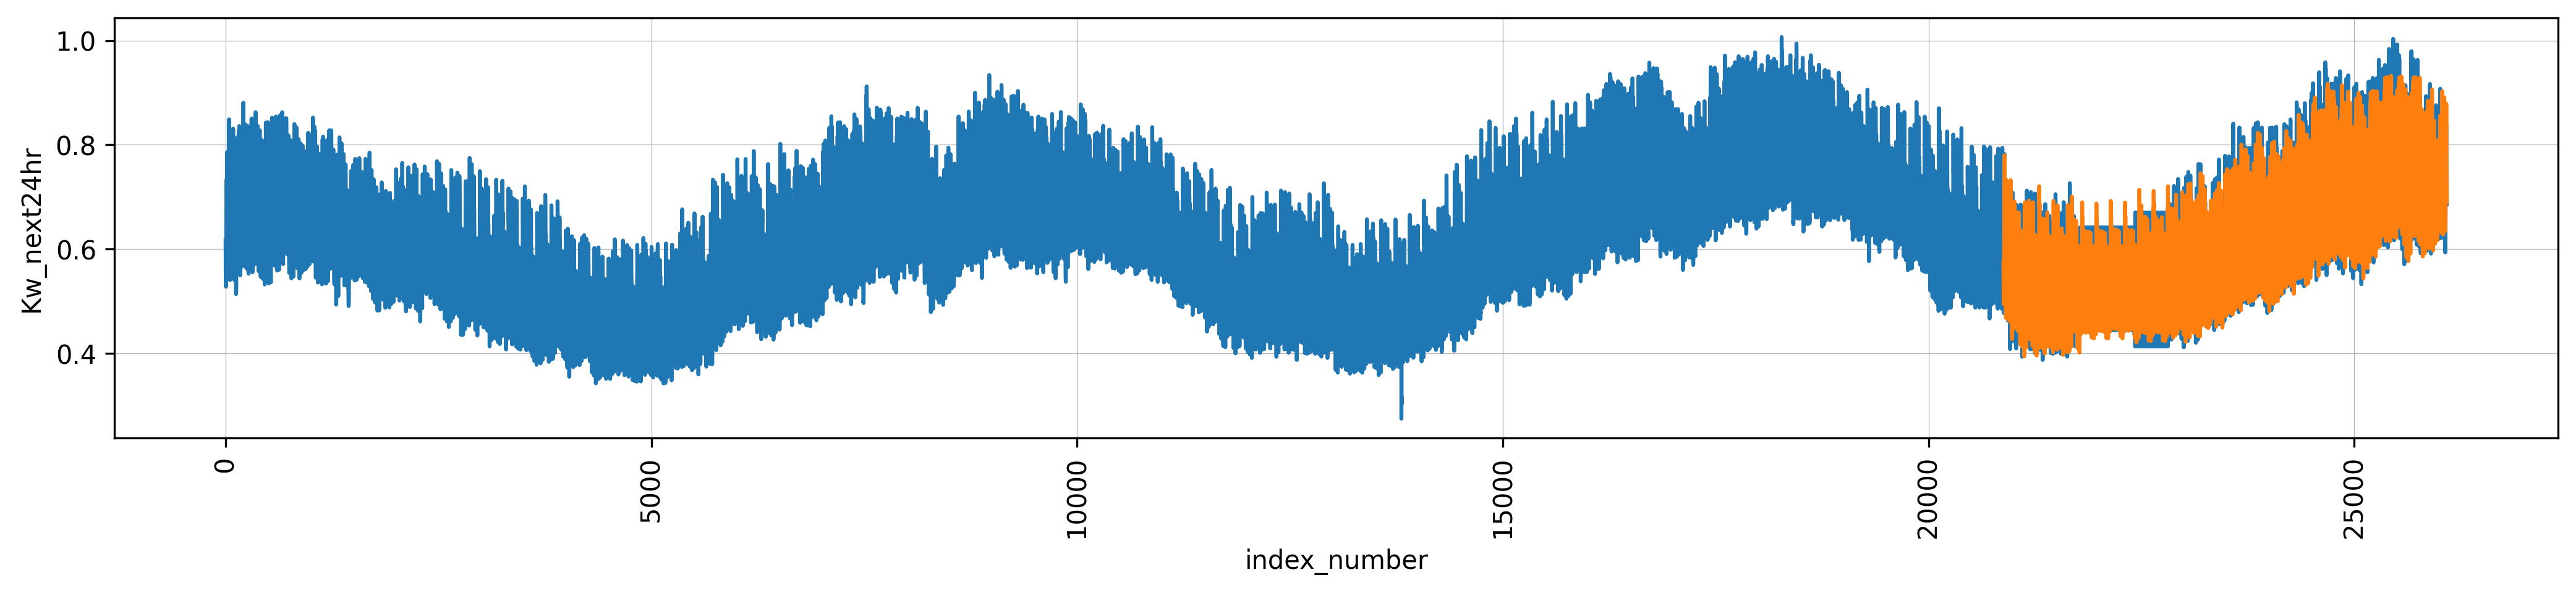

In [263]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1_shifted_vis, x='index_number', y='Kw_next24hr')
sns.lineplot(data=df_predictions, x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

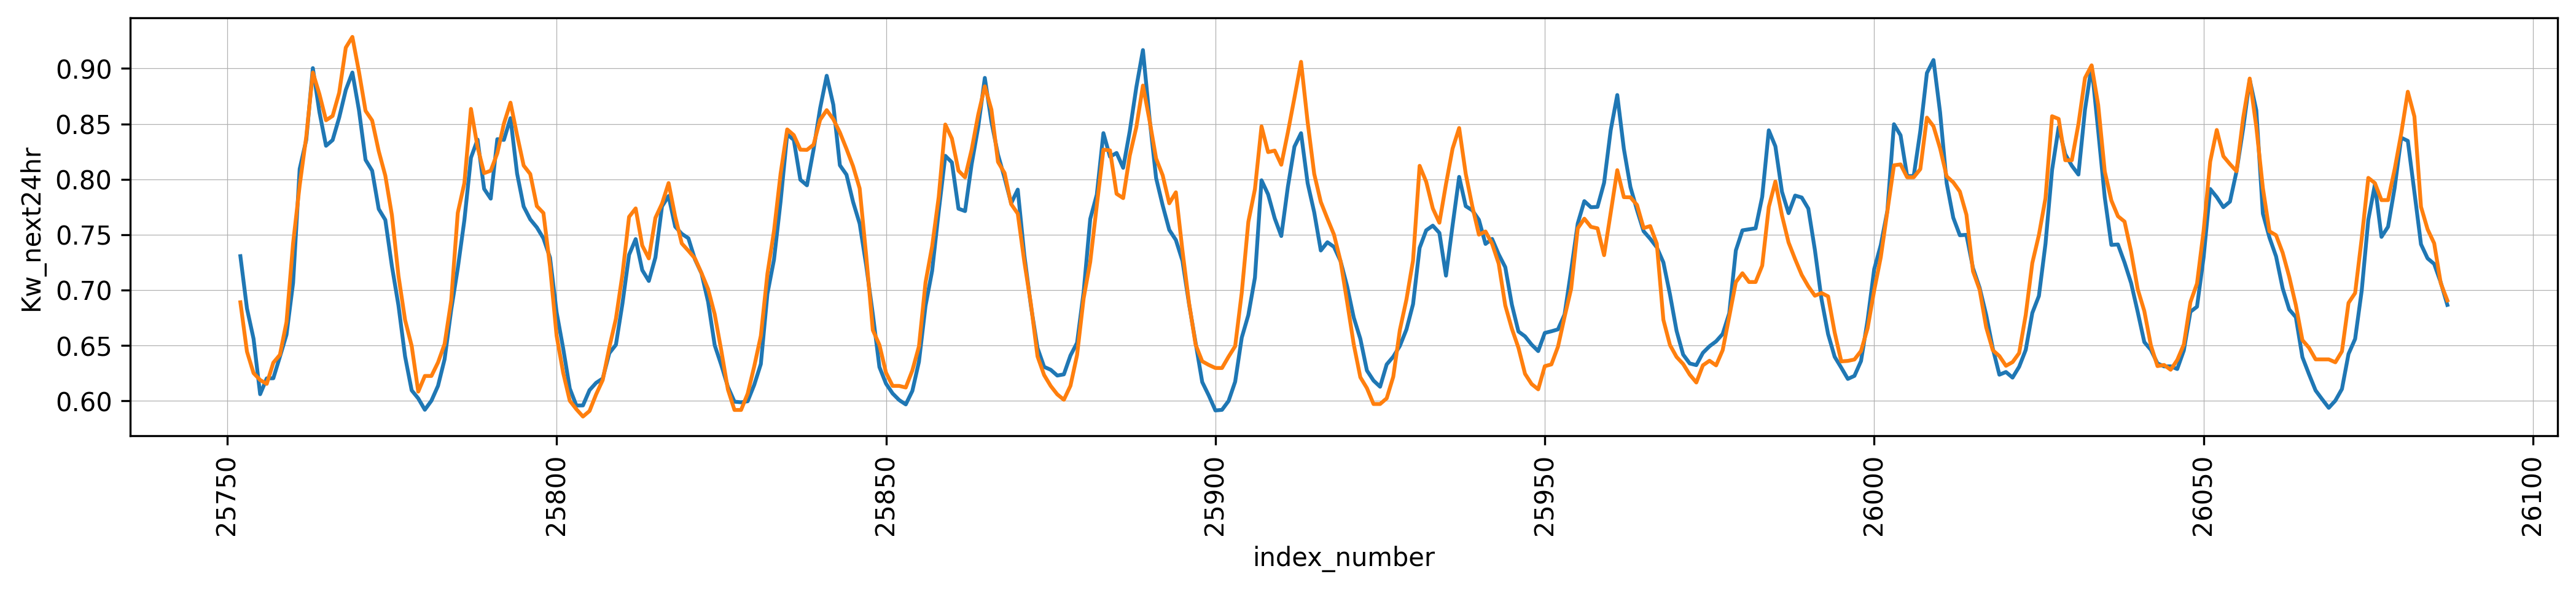

In [264]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1_shifted_vis.tail(336), x='index_number', y='Kw_next24hr')
sns.lineplot(data=df_predictions.tail(336), x= 'test_index', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()